In [1]:
import numpy as np
import pandas as pd
import rebound
import dask.dataframe as dd
from celmech import *

In [2]:
respath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/resonant/'
sapath = 'simulation_archives/runs/sa'

# Use this first simulation as a testing example

In [3]:
sa = rebound.SimulationArchive(respath+sapath+'0000000.bin')
sim = sa[0]

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [4]:
print('P2/P1', sim.particles[2].P/sim.particles[1].P)
print('P3/P2', sim.particles[3].P/sim.particles[2].P)

P2/P1 1.8445744838304716
P3/P2 1.0916975177402766


The inner two planets are close to 12:11 (1.0909 period ratio) resonance, so set the indices to the outer two:

In [5]:
i1 = 2
i2 = 3

# There's a first transformation I forgot to mention to 'averaged variables' 

It essentially tries to take away the effects of conjunctions where an inner planet overtakes an outer one, where the orbital elements will jump up and then back down. This is not really necessary if you start far from a conjunction, but if you're trying to get resonant variables at a snapshot that's undergoing a conjunction, then the orbital elements you'd use would not be representative of the whole orbit. These are small corrections that look a lot like forces and I think make sense in a graphnet. For each pair of planets you calculate equal and opposite corrections on each particle's semimajor axis, which is weighted by the other's mass. 

In [6]:
poinc = Poincare.from_Simulation(sim)

# Resonance Strengths

This function calculates resonance strengths for a j:j-k resonance given masses (m), mean motions = 2pi/orbital period (n), eccentricities (e) and longitude of pericenter (pomega) for each body

In [7]:
def calc_res_strength(j, k, m1, m2, n1, n2, e1, e2, pomega1, pomega2):
    Z = np.sqrt((e1*np.cos(pomega1) - e2*np.cos(pomega2))**2 + (e1*np.sin(pomega1) - e2*np.sin(pomega2))**2)
    return np.abs(np.sqrt(m1+m2)*Z**(k/2.)/(j*n2 - (j-k)*n1))

# Finding the Strong Resonances

This function in celmech takes a min period ratio, max period ratio and a maximum order resonance to consider (we want to set this to two). It then returns a list of all the resonances that lie in that period range. The period ratio should be less than one, i.e. Period(inner)/P(outer). You'd look through all the pairs (or adjacent pairs), but here we've already figured out which particles indices are closest to resonance

In [8]:
from celmech.resonances import resonant_period_ratios

delta = 0.03
Pratio = sim.particles[i1].P/sim.particles[i2].P
res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=2)

In [9]:
ps = poinc.particles
res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=2)
strengths = np.zeros((len(res), 3))
for i, (a, b) in enumerate(res):
    j = b
    k = b-a
    strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
    
for res in sortedstrengths:
    print(int(res[0]), int(res[1]), res[2])

12 1 0.04824427381301188
11 1 0.0023070135609413005
13 1 0.0021056332109779573
10 1 0.0011265707951570027
14 1 0.0010763043905751453
9 1 0.0007452463510067455
15 1 0.0007229121907158289
16 1 0.0005442228582438629
17 1 0.00043636277066132716
23 2 0.0004265723762116975
18 1 0.0003641846421540085
25 2 0.000355215345756078
21 2 0.00013326705829331707
27 2 0.00012539726720066434
19 2 7.896903347674869e-05
29 2 7.613758765659086e-05
31 2 5.466398904442725e-05
33 2 4.263839439538971e-05
35 2 3.494975669386216e-05
37 2 2.9610359439953797e-05


# Max strength is for the j=12, k=1 = 12:11 (j:j-k) resonance as expected

In [10]:
strongres = sortedstrengths[0]
print(strongres)

[12.          1.          0.04824427]


# Compare the simplified resonance model evolution (orange) to the Nbody one in resonance variables

In [11]:
from celmech import Andoyer, AndoyerHamiltonian
import matplotlib.pyplot as plt
%matplotlib inline

j = int(strongres[0])
k = int(strongres[1])

andvars = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2)
H = AndoyerHamiltonian(andvars)
tmax=100*andvars.params['tau']
Nout = 1000
times = np.linspace(0, tmax, Nout)

Z, phi = np.zeros(Nout), np.zeros(Nout)
NZ, Nphi = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    H.integrate(time)
    sim.integrate(time)
    Z[i] = H.state.Z
    phi[i] = H.state.phi
    NZ[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).Z
    Nphi[i] = Andoyer.from_Simulation(sim=sim, j=j, k=k, i1=i1, i2=i2).phi

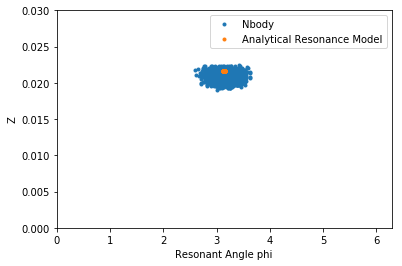

In [12]:
fig, ax = plt.subplots()
ax.plot(Nphi, NZ, '.', label='Nbody')
ax.plot(phi, Z, '.', label='Analytical Resonance Model')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 0.03])
ax.set_xlabel('Resonant Angle phi')
ax.set_ylabel('Z')
ax.legend()

In [29]:
def transform_to_res(row, j, k, i1, i2):
    sim = rebound.SimulationArchive(respath+sapath+row['runstring'])[0]
    pvars = Poincare.from_Simulation(sim)
    a10 = sim.particles[i1].a
    ps = poinc.particles
    avars = Andoyer.from_Poincare(pvars, j=j, k=k, a10=a10, i1=i1, i2=i2)
    row['j'] = j
    row['k'] = k
    row['m1'] = ps[i1].m
    row['m2'] = ps[i2].m
    row['n1'] = ps[i1].n
    row['n2'] = ps[i2].n
    row['acosl1'] = ps[i1].a*np.cos(ps[i1].l)
    row['asinl1'] = ps[i1].a*np.sin(ps[i1].l)
    row['acosl2'] = ps[i2].a*np.cos(ps[i2].l)
    row['asinl2'] = ps[i2].a*np.sin(ps[i2].l)
    row['k1'] = ps[i1].e*np.cos(ps[i1].pomega)
    row['h1'] = ps[i1].e*np.sin(ps[i1].pomega)
    row['k2'] = ps[i2].e*np.cos(ps[i2].pomega)
    row['h2'] = ps[i2].e*np.sin(ps[i2].pomega)
    
    row['Zcosphi'] = avars.Z*np.cos(avars.phi)
    row['Zsinphi'] = avars.Z*np.sin(avars.phi)
    row['Zcomcosphi'] = avars.Zcom*np.cos(avars.phiZcom)
    row['Zcomsinphi'] = avars.Zcom*np.sin(avars.phiZcom)
    row['Zstarcostheta'] = avars.Zstar*np.cos(avars.theta)
    row['Zstarsintheta'] = avars.Zstar*np.sin(avars.theta)
    row['dKprimecostheta1'] = avars.dKprime*np.cos(avars.theta1)
    row['dKprimesintheta1'] = avars.dKprime*np.sin(avars.theta1)
    
    return row

def return_nan(row):
    row['j'] = np.nan
    row['k'] = np.nan
    row['m1'] = np.nan
    row['m2'] = np.nan
    row['n1'] = np.nan
    row['n2'] = np.nan
    row['acosl1'] = np.nan
    row['asinl1'] = np.nan
    row['acosl2'] = np.nan
    row['asinl2'] = np.nan
    row['k1'] = np.nan
    row['h1'] = np.nan
    row['k2'] = np.nan
    row['h2'] = np.nan
    
    row['Zcosphi'] = np.nan
    row['Zsinphi'] = np.nan
    row['Zcomcosphi'] = np.nan
    row['Zcomsinphi'] = np.nan
    row['Zstarcostheta'] = np.nan
    row['Zstarsintheta'] = np.nan
    row['dKprimecostheta1'] = np.nan
    row['dKprimesintheta1'] = np.nan
    return row

# Test function

Zcosphi = -0.02 and Zsinphi = 0 as expected from above

In [34]:
df = pd.read_csv(respath+'resonant.csv', index_col=0)
testres = transform_to_res(df.loc[0], 12, 1, 2, 3)
testres

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


runstring           0000000.bin
j                            12
k                             1
m1                   1.2444e-05
m2                   2.5317e-07
n1                      3.40626
n2                      3.12133
acosl1               -0.0691019
asinl1                  1.50248
acosl2                 -1.21184
asinl2                  1.03591
k1                    0.0413698
h1                  -0.00716343
k2                    0.0274155
h2                    0.0205153
Zcosphi              -0.0216463
Zsinphi            -0.000282459
Zcomcosphi            0.0411389
Zcomsinphi          -0.00662648
Zstarcostheta        0.00905754
Zstarsintheta        -0.0196584
dKprimecostheta1    5.52506e-06
dKprimesintheta1    7.58103e-07
Name: 0, dtype: object

In [35]:
from random import randint, seed

seed(0)

def choose_res(row):
    sim = rebound.SimulationArchive(respath+sapath+row['runstring'])[0]
    i1 = randint(1,2) # choose inner index randomly
    i2 = i1+1 # take adjacent planet
    
    delta = 0.03
    Pratio = sim.particles[i1].P/sim.particles[i2].P
    res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=2)
    strengths = np.zeros((len(res), 3))
    for i, (a, b) in enumerate(res):
        j = b
        k = b-a
        strengths[i] = [j, k, calc_res_strength(j, k, ps[i1].m, ps[i2].m, ps[i1].n, ps[i2].n, ps[i1].e, ps[i2].e, ps[i1].pomega, ps[i2].pomega)]

    try:
        sortedstrengths = strengths[strengths[:,2].argsort()][::-1]
        index = randint(0,2) # choose one of the top 3 strengths
        r = sortedstrengths[index]
        j = int(r[0])
        k = int(r[1])
        return transform_to_res(row, j, k, i1, i2)
    except:
        return return_nan(row)

In [36]:
%%time
ddf = dd.from_pandas(df, npartitions=24)
res = ddf.apply(choose_res, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/celmech/celmech/andoyer.py:34: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.s

CPU times: user 593 ms, sys: 315 ms, total: 908 ms
Wall time: 13.6 s


In [37]:
res = res[~res['j'].isnull()]

In [39]:
res

,runstring,j,k,m1,m2,n1,n2,acosl1,asinl1,acosl2,...,k2,h2,Zcosphi,Zsinphi,Zcomcosphi,Zcomsinphi,Zstarcostheta,Zstarsintheta,dKprimecostheta1,dKprimesintheta1
1,0000001.bin,11.0,1.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,...,0.027416,0.020515,-0.054414,0.028638,0.009971,-0.003819,-1.867980e-03,0.055839,0.000257,-6.912172e-06
4,0000004.bin,11.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,...,0.041370,-0.007163,-0.010741,0.013890,-0.019605,0.034651,-9.856052e-03,-0.021746,-0.000362,1.569533e-04
5,0000005.bin,5.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,...,0.041370,-0.007163,0.026202,0.012822,0.014104,-0.043812,1.010218e-04,-0.000073,0.000507,8.492594e-03
7,0000007.bin,13.0,2.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,...,0.027416,0.020515,-0.013692,-0.001583,0.013536,-0.006935,NaN,NaN,0.004445,-6.450357e-04
10,0000010.bin,11.0,2.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,...,0.041370,-0.007163,-0.053730,0.018822,-0.064764,-0.051393,-6.524573e-02,-0.011115,-0.004238,1.593886e-03
11,0000011.bin,9.0,2.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,...,0.027416,0.020515,-0.029258,0.010859,0.014375,-0.037967,NaN,NaN,0.001466,-4.173041e-04
12,0000012.bin,6.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,...,0.041370,-0.007163,-0.002403,-0.006144,0.002201,-0.009491,-1.086008e-03,0.000704,0.001392,-2.186491e-04
13,0000013.bin,4.0,1.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,...,0.027416,0.020515,-0.030817,0.032243,0.017155,0.041289,7.382900e-02,0.009788,-0.004339,-3.460465e-03
14,0000014.bin,12.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,...,0.041370,-0.007163,-0.006345,-0.003768,-0.002912,0.001300,-1.734040e-02,-0.008141,-0.002820,-5.144419e-05
16,0000016.bin,12.0,1.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,...,0.027416,0.020515,-0.002274,-0.000226,0.000833,0.004725,-1.990672e-04,-0.000004,0.001634,-6.845133e-04


In [40]:
res.columns

Index(['runstring', 'j', 'k', 'm1', 'm2', 'n1', 'n2', 'acosl1', 'asinl1',
       'acosl2', 'asinl2', 'k1', 'h1', 'k2', 'h2', 'Zcosphi', 'Zsinphi',
       'Zcomcosphi', 'Zcomsinphi', 'Zstarcostheta', 'Zstarsintheta',
       'dKprimecostheta1', 'dKprimesintheta1'],
      dtype='object')

In [42]:
X = res[['j', 'k', 'm1', 'm2', 'n1', 'n2', 'acosl1', 'asinl1', 'acosl2', 'asinl2', 'k1', 'h1', 'k2', 'h2']]
y = res[['Zcosphi', 'Zsinphi', 'Zcomcosphi', 'Zcomsinphi', 'Zstarcostheta', 'Zstarsintheta', 'dKprimecostheta1', 'dKprimesintheta1']]

In [45]:
X.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv')
y.to_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv')

In [46]:
X = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationinput.csv', index_col=0)
X.head()

,j,k,m1,m2,n1,n2,acosl1,asinl1,acosl2,asinl2,k1,h1,k2,h2
1,11.0,1.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,1.035913,0.041370,-0.007163,0.027416,0.020515
4,11.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,1.502485,0.000022,-0.000175,0.041370,-0.007163
5,5.0,1.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,1.502485,0.000022,-0.000175,0.041370,-0.007163
7,13.0,2.0,0.000012,2.531702e-07,3.406265,3.121326,-0.069102,1.502485,-1.211841,1.035913,0.041370,-0.007163,0.027416,0.020515
10,11.0,2.0,0.000004,1.244402e-05,6.283090,3.406265,-0.982936,-0.184002,-0.069102,1.502485,0.000022,-0.000175,0.041370,-0.007163


In [47]:
y = pd.read_csv('/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/csvs/restransformationlabels.csv', index_col=0)
y.head()

,Zcosphi,Zsinphi,Zcomcosphi,Zcomsinphi,Zstarcostheta,Zstarsintheta,dKprimecostheta1,dKprimesintheta1
1,-0.054414,0.028638,0.009971,-0.003819,-0.001868,0.055839,0.000257,-0.000007
4,-0.010741,0.013890,-0.019605,0.034651,-0.009856,-0.021746,-0.000362,0.000157
5,0.026202,0.012822,0.014104,-0.043812,0.000101,-0.000073,0.000507,0.008493
7,-0.013692,-0.001583,0.013536,-0.006935,NaN,NaN,0.004445,-0.000645
10,-0.053730,0.018822,-0.064764,-0.051393,-0.065246,-0.011115,-0.004238,0.001594


In [48]:
X.shape

(6670, 14)